<a href="https://colab.research.google.com/github/Robot-Wealth/rsims/blob/main/examples/A_simple_trick_to_minimise_trading_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Trick for Minimising Trading Costs

Here's a thing that is quite well known in quant trading circles, but beginners probably haven’t heard about. It’s a surprisingly simple heuristic for minimising your turnover called the "no trade region" technique.

A good thing to remember is that your edge is uncertain - not only do you usually not know how big it is, you also don’t know if it even exists anymore.

On the other hand, your trading costs are absolutely certain. Every time you click "buy" or "sell," you're paying for the privilege.

One of the most powerful improvements to any strategy is simply trading less.

Or more accurately, doing the bare minimum amount of trading required to harness your edge.

## The no-trade region: A powerful heuristic

Here's how it works:

Your strategy generates a target position (w) for each asset. But instead of immediately trading to that exact position, you create a buffer zone (b) around it.

For a minimum commission cost structure (where there is some fixed minimum commission):

* If your current position (w0) is below w-b, trade up to w
* If your current position is above w+b, trade down to w
* If your position falls within this "no trade region," do nothing

If your costs are only a function of size, you would trade to the edge of the barrier instead:

* If your current position (w0) is below w-b, trade up to w-b
* If your current position is above w+b, trade down to w+b
* If your position falls within this "no trade region," do nothing

This simple rule dramatically reduces unnecessary churn while still keeping you reasonably aligned with your strategy's intentions.

## How big should your buffer be?

The simplest approach is to just run a bunch of simulations and find the value that maximises after-cost Sharpe ratio.

This might sound like overfitting, but so long as you think carefully about what you’re doing, it’s not a huge deal. It’s certainly not on the same level as fitting a trend rule to the 127-day moving average!

However, a sensible way to view a backtest is that it likely overstates performance.

Like it or not, some sort of bias will usually creep in to the development process - recognising this, I view any backtest as an absolute upper limit on expected performance going forward.

The implication is that optimising the buffer value on backtested Sharpe will produce a value that is too low, since the backtest is a little overestimated.

So it’s not a bad idea to increase the value of the buffer over what you found in your backtest.

I’ve heard of people doubling this value; personally, I would add say 25-50%. But it depends on what you're doing.  

This simple technique can have quite an impact. While it isn’t an edge in itself, it can help you harness edges that would otherwise not survive trading costs.


## Exploring the no trade barrier with rsims

rsims is a library for doing simulations for trading. It includes functions for doing backtesting with the no trade barrier.

First, load the necessary libraries and set up charting options (this can take a minute or two for a fresh Colab instance).

In [1]:
# install and load libraries
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
quiet_setup <- purrr::quietly(.f = load_libraries)
debug_msg <- quiet_setup(load_rsims = TRUE, extra_libraries = c(), extra_dependencies = c())

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Load the data that comes with rsims. This is simply price data for 7 ETFs and the weights needed to achieve an equal weight allocation to each.

In [2]:
data(equal_weight_etfs)
head(equal_weight_etfs)

ticker,date,unadjusted_close,close,weight
<chr>,<date>,<dbl>,<dbl>,<dbl>
EMB,1995-01-04,40.22193,20.88572,0.1428571
GLD,1995-01-04,39.93568,39.80411,0.1428571
IEF,1995-01-04,43.80437,25.73871,0.1428571
TLT,1995-01-04,40.78683,21.15342,0.1428571
VEA,1995-01-04,22.07549,14.57201,0.1428571
VTI,1995-01-04,18.97111,13.25305,0.1428571


Set up data in correct format for rsims (wide matrixes):

In [3]:
wide_prices <- equal_weight_etfs %>%
  select(ticker, date, close) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = close) %>%
  data.matrix()

# wide_prices[is.na(wide_prices)] <- 0

wide_unadjprices <- equal_weight_etfs %>%
  select(ticker, date, unadjusted_close) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = unadjusted_close) %>%
  data.matrix()

wide_weights <- equal_weight_etfs %>%
  select(ticker, date, weight) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = weight) %>%
  data.matrix()

This function runs a backtest using the Interactive Brokers minimum commission model that applies to tiered accounts trading US equities. In this case we don't reinvest profits; we just let an excess cash balance accrue.

For the sake of the example, it doesn't include interest earned.

Initially, set the trade buffer parameter to zero so that the strategy rebalances daily.


In [54]:
# minimum commission backtest

max_pct_per_order <- 0.01
min_dollars_per_order <- 0.35
dollars_per_share <- 0.0035
initial_cash <- 50000

results_df <- rsims::min_commission_backtest(
    wide_prices,
    wide_unadjprices,
    wide_weights,
    interest_rates = NULL,
    short_borrow_costs = NULL,
    trade_buffer = 0,
    initial_cash = initial_cash,
    capitalise_profits = FALSE,
    us_tiered_commission,
    max_pct_per_order = max_pct_per_order,
    min_dollars_per_order = min_dollars_per_order,
    dollars_per_share = dollars_per_share
  )

tail(results_df)

ticker,date,close,shares,exposure,share_trades,trade_value,commission,interest,short_borrow,margin_call,reduced_target_pos
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
GLD,2021-09-30,164.22,43,7061.46,-1,-164.22,0.35,0,0,FALSE,FALSE
IEF,2021-09-30,115.22,61,7028.42,-1,-115.22,0.35,0,0,FALSE,FALSE
TLT,2021-09-30,144.32,49,7071.68,0,0.00,0.00,0,0,FALSE,FALSE
VEA,2021-09-30,50.49,141,7119.09,0,0.00,0.00,0,0,FALSE,FALSE
VTI,2021-09-30,222.06,32,7105.92,1,222.06,0.35,0,0,FALSE,FALSE
VWO,2021-09-30,50.01,142,7101.42,-1,-50.01,0.35,0,0,FALSE,FALSE


Output some performance metrics and a chart of performance:

Ann.Return(%),Ann.Volatility(%),Ann.Sharpe,Ave.Ann.Turnover(%),Tot.Profit($),Costs(%Profit)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.116624,5.674156,0.7255042,49.38621,93839.06,10.71099


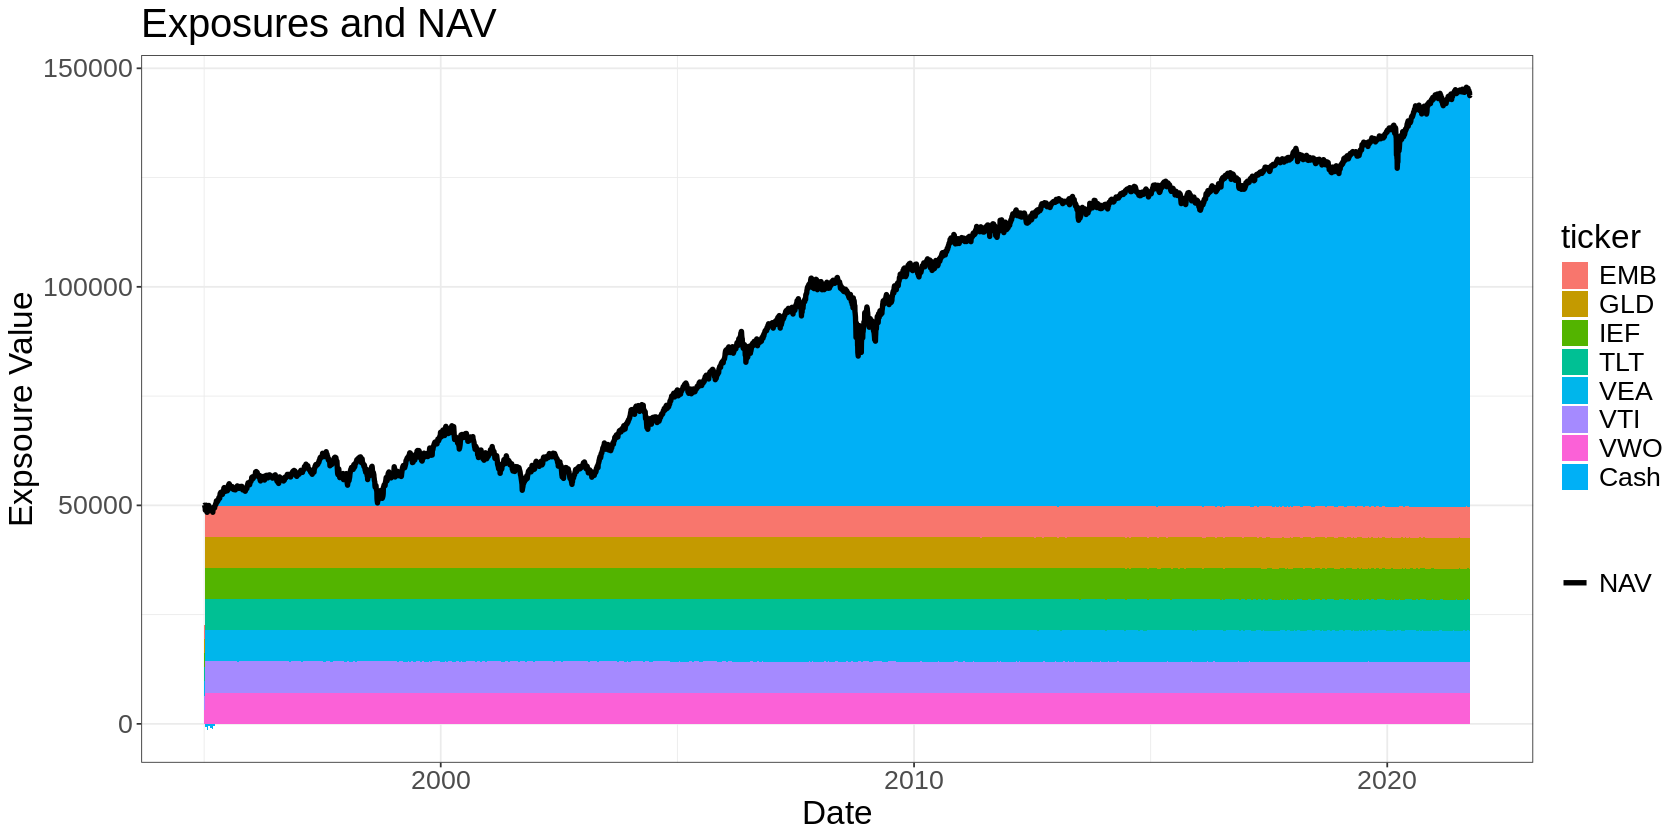

In [55]:
# make nice colour pallettes and scales
tickers <- unique(equal_weight_etfs$ticker)
cols <- portfolio_colours(tickers)
fill_scale <- make_fill_scale(cols)
colour_scale <- make_col_scale(cols)

# summary statistics
summary_performance(results_df, initial_equity = initial_cash)

# exposures and NAV over time
results_df %>%
  append_nav_to_bt_results() %>%
  stacked_area_chart("Exposures and NAV", tickers = tickers, colours = cols)

The colours represent the exposure to each asset in the portoflio. The blue represents the cash balance, which grows over time as the value of the underlying assets goes up.

You can see that the asset exposures are rebalanced back to equal dollar weight on a daily basis.

In the performance metrics, notice that the costs as a percentage of the strategy's profits was over 10%

Let's look at daily trade value:

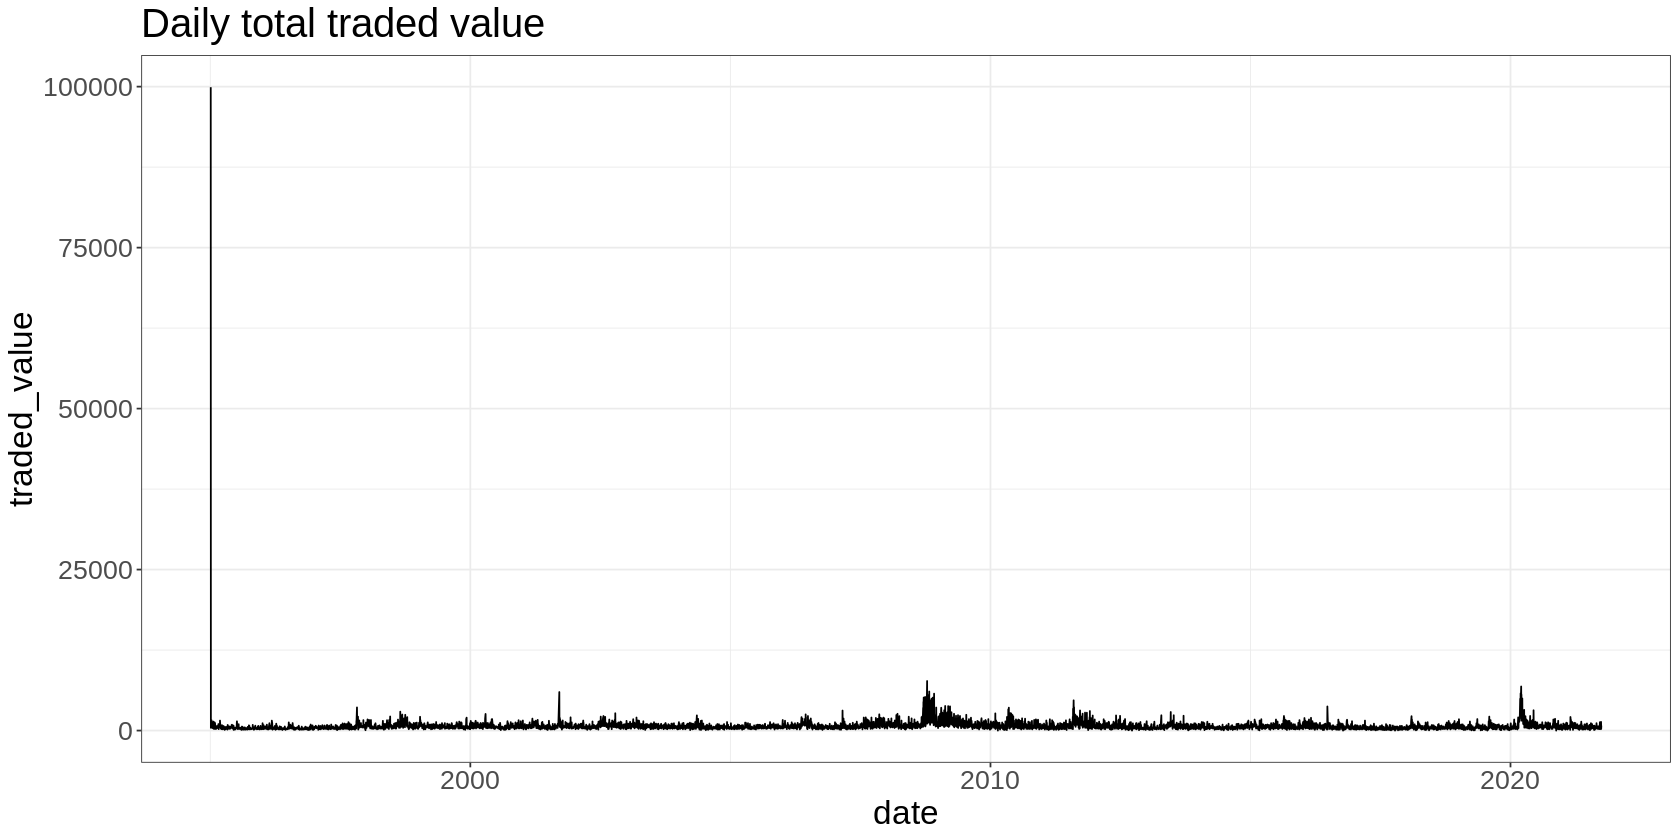

In [35]:
results_df %>%
  filter(ticker != "Cash") %>%
  group_by(date) %>%
  summarise(traded_value = sum(abs(trade_value))) %>%
  ggplot(aes(x = date, y = traded_value)) +
  geom_line() +
  labs(
   title = "Daily total traded value"
  )


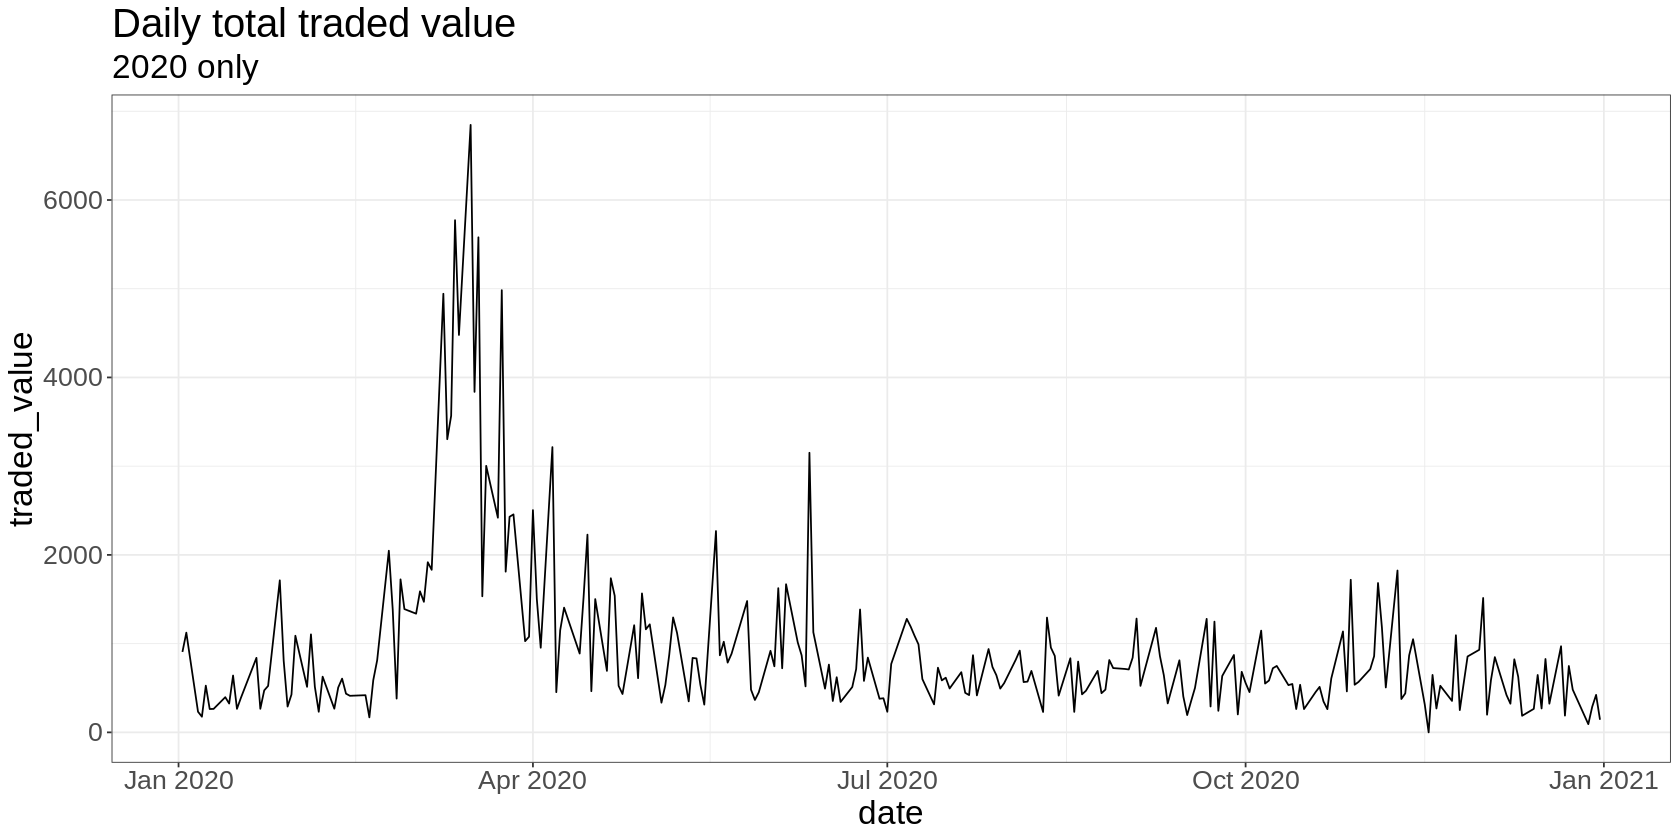

In [36]:
results_df %>%
  filter(date >= "2020-01-01", date <= "2020-12-31") %>%
  filter(ticker != "Cash") %>%
  group_by(date) %>%
  summarise(traded_value = sum(abs(trade_value))) %>%
  ggplot(aes(x = date, y = traded_value)) +
  geom_line() +
  labs(
   title = "Daily total traded value",
   subtitle = "2020 only"
  )


Here's a chart of commissions by asset over time:

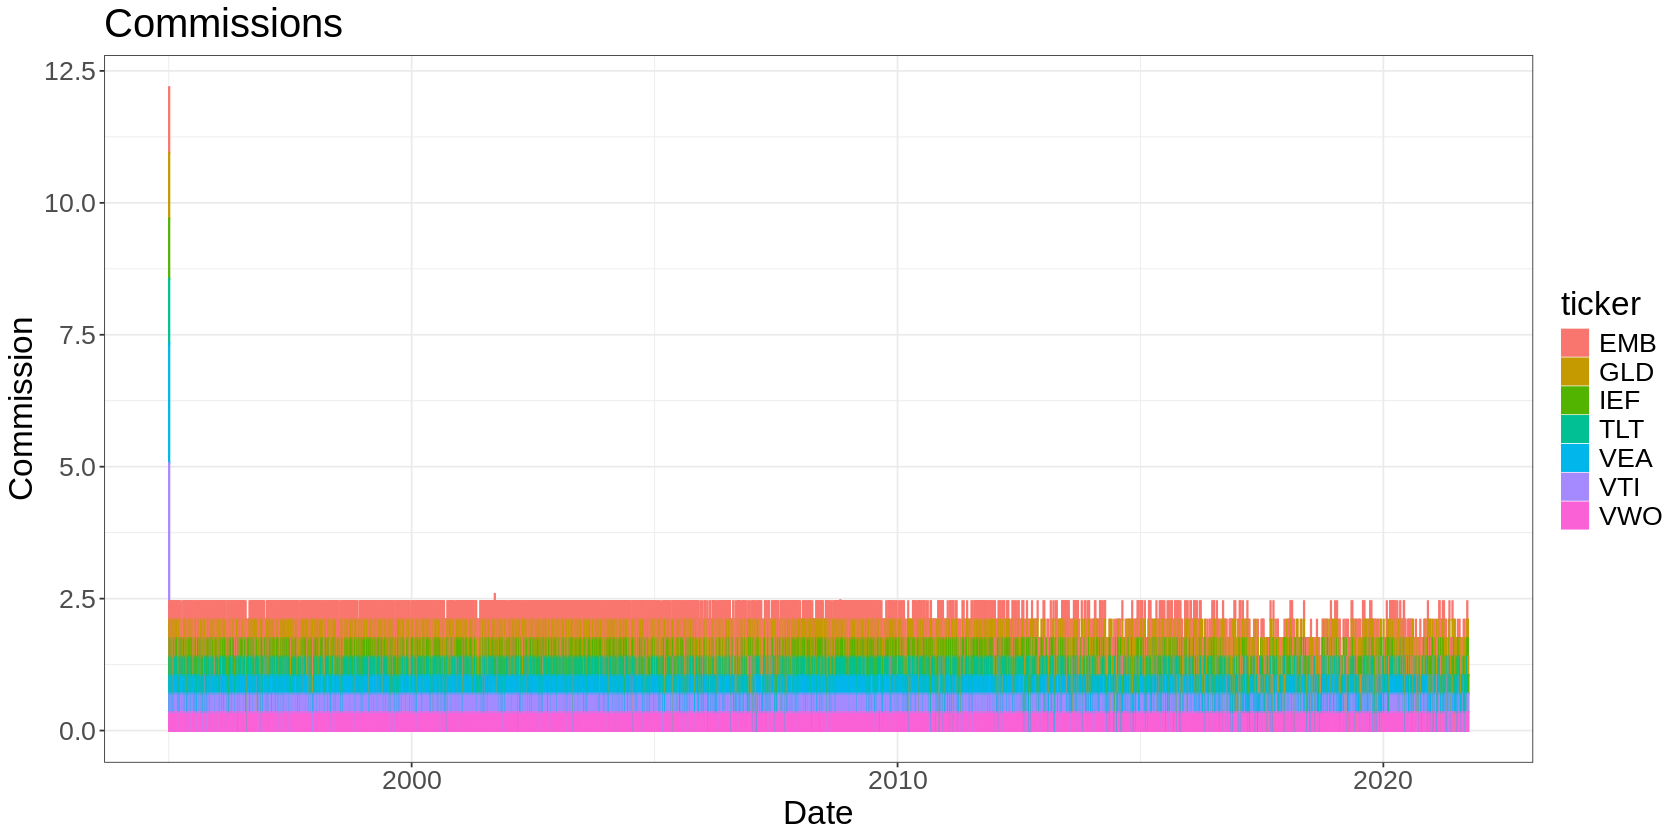

In [37]:
comm_chart(results_df, "Commissions", fill_scale, colour_scale)

Zoom in to 2020:

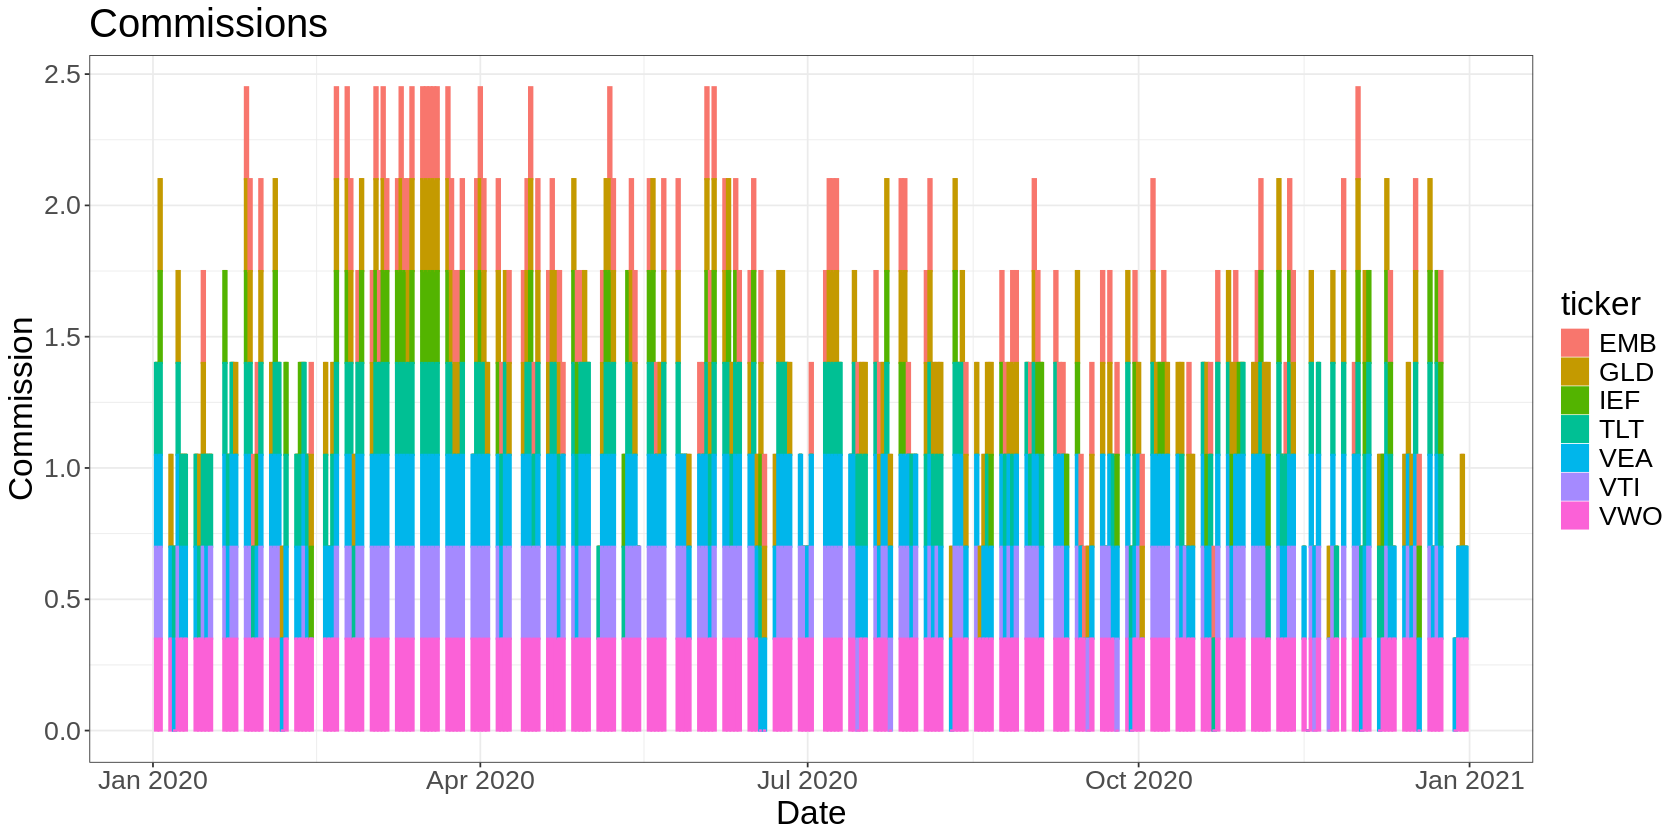

In [38]:
comm_chart(results_df %>% filter(date >= "2020-01-01", date <= "2020-12-31"), "Commissions", fill_scale, colour_scale)

You can see that the strategy is trading and accruing commissions most days, and that it's turning over a relatively large amount of the total portfolio value.

Next we optimise the no trade barrier by running a bunch of backtests and calculating the after-cost Sharpe for each value of the trade barrier. We test all values from zero to 0.15 incrementing by 0.01.

In [49]:
# function for calculating Sharpe ratio given 365 day/year trading
calc_sharpe <- function(backtest_results) {
  backtest_results %>%
    group_by(date) %>%
    summarise(Equity = sum(exposure, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

# run simulation for multiple trade buffer values
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    # minimum commission backtest
    rsims::min_commission_backtest(
      wide_prices,
      wide_unadjprices,
      wide_weights,
      interest_rates = NULL,
      short_borrow_costs = NULL,
      trade_buffer = trade_buffer,
      initial_cash = initial_cash,
      capitalise_profits = FALSE,
      us_tiered_commission,
      max_pct_per_order = max_pct_per_order,
      min_dollars_per_order = min_dollars_per_order,
      dollars_per_share = dollars_per_share
    ) %>%
      calc_sharpe()
  )
}

sharpes

[[1]]
[1] 0.8993744

[[2]]
[1] 0.9771263

[[3]]
[1] 1.007334

[[4]]
[1] 1.014812

[[5]]
[1] 1.061443

[[6]]
[1] 1.059718

[[7]]
[1] 1.069015

[[8]]
[1] 1.077316

[[9]]
[1] 1.049731

[[10]]
[1] 1.116322

[[11]]
[1] 1.089215

Plot the results, noting the optimal value:

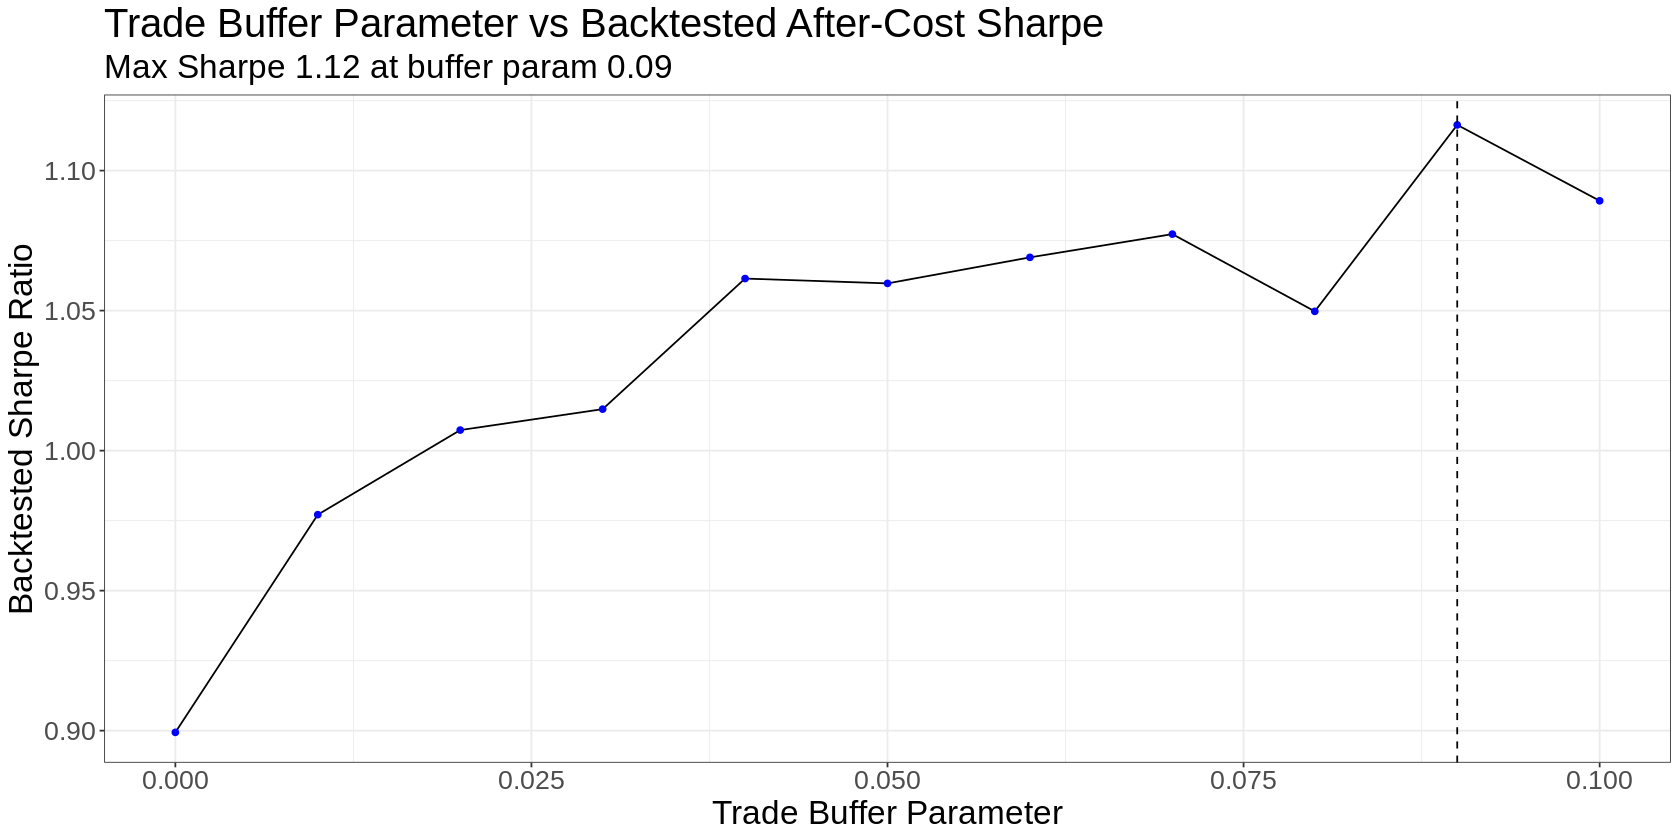

In [50]:
sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  na.omit() %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue::glue("Trade Buffer Parameter vs Backtested After-Cost Sharpe"),
      subtitle = glue::glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

For the sake of the example, let's increase the trade barrier to 0.05 - the point where after-cost Sharpe starts to level off.

(In reality you could probably go even higher - the trade off would be a higher tracking error but even less trading).

In [56]:
optimal_trade_buffer <- 0.05

results_df <- rsims::min_commission_backtest(
    wide_prices,
    wide_unadjprices,
    wide_weights,
    interest_rates = NULL,
    short_borrow_costs = NULL,
    trade_buffer = optimal_trade_buffer,
    initial_cash = initial_cash,
    capitalise_profits = FALSE,
    us_tiered_commission,
    max_pct_per_order = 0.01,
    min_dollars_per_order = 0.35,
    dollars_per_share = 0.0035
  )

Ann.Return(%),Ann.Volatility(%),Ann.Sharpe,Ave.Ann.Turnover(%),Tot.Profit($),Costs(%Profit)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.477499,5.005155,0.8945776,4.934622,109913.9,0.02636968


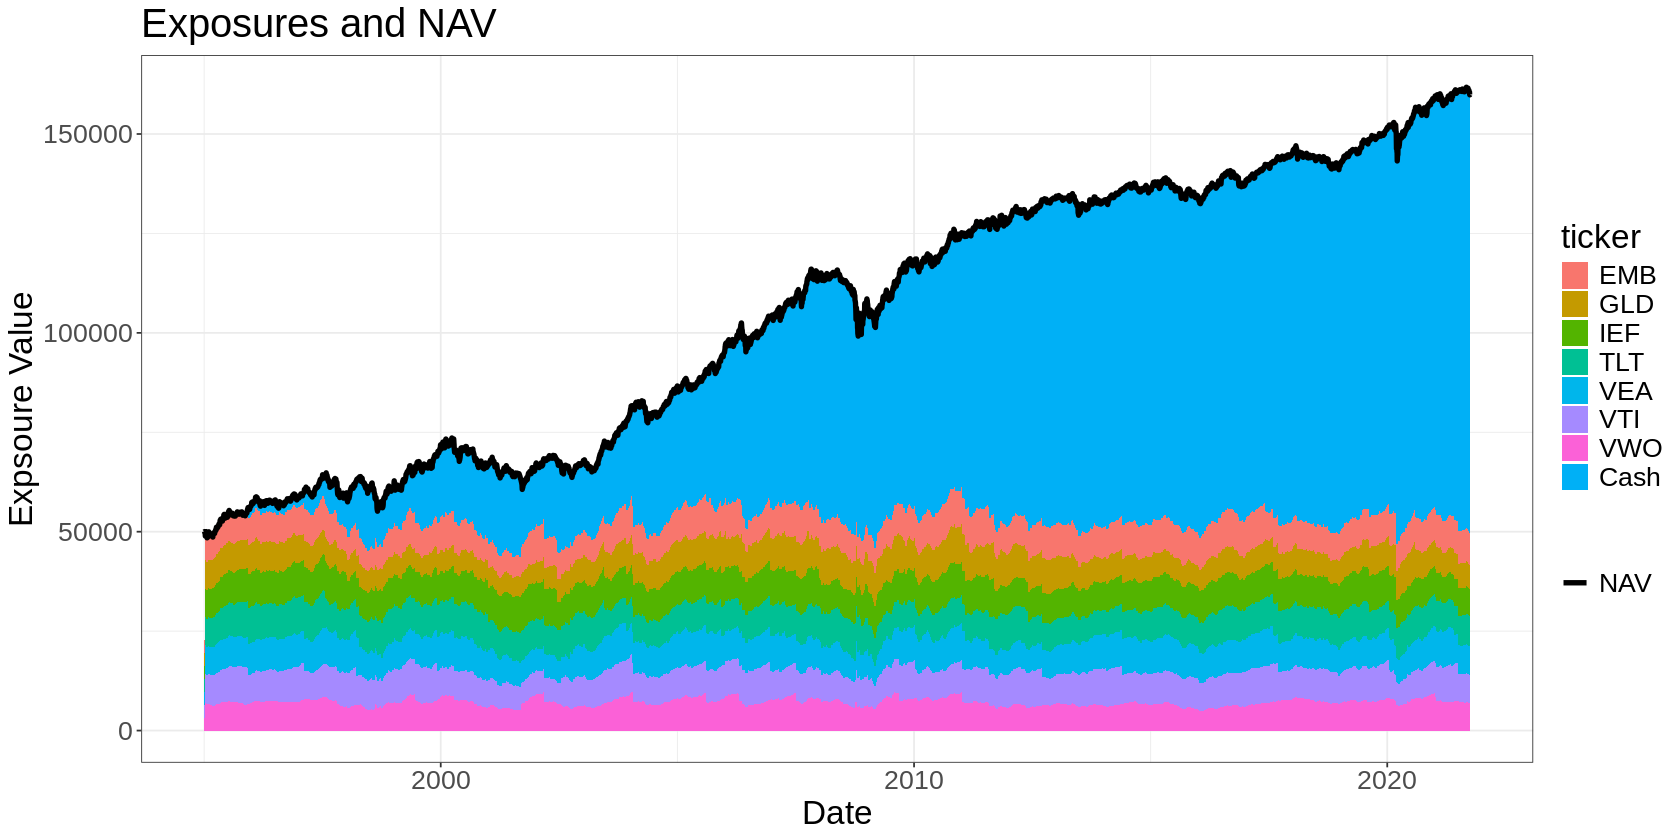

In [57]:
# summary statistics
summary_performance(results_df, initial_equity = initial_cash)

# exposures and NAV over time
results_df %>%
  append_nav_to_bt_results() %>%
  stacked_area_chart("Exposures and NAV", tickers = tickers, colours = cols)

Notice that you get a higher after-cost Sharpe (0.9 vs 0.75), a much lower turnover and a much lower cost component.

The trade off is the large tracking error. You can see that our asset weights deviate quite far from equality, whereas when we rebalanced every day, they were virtually constant.


When we look at the volume of trading, we're barely trading at all:

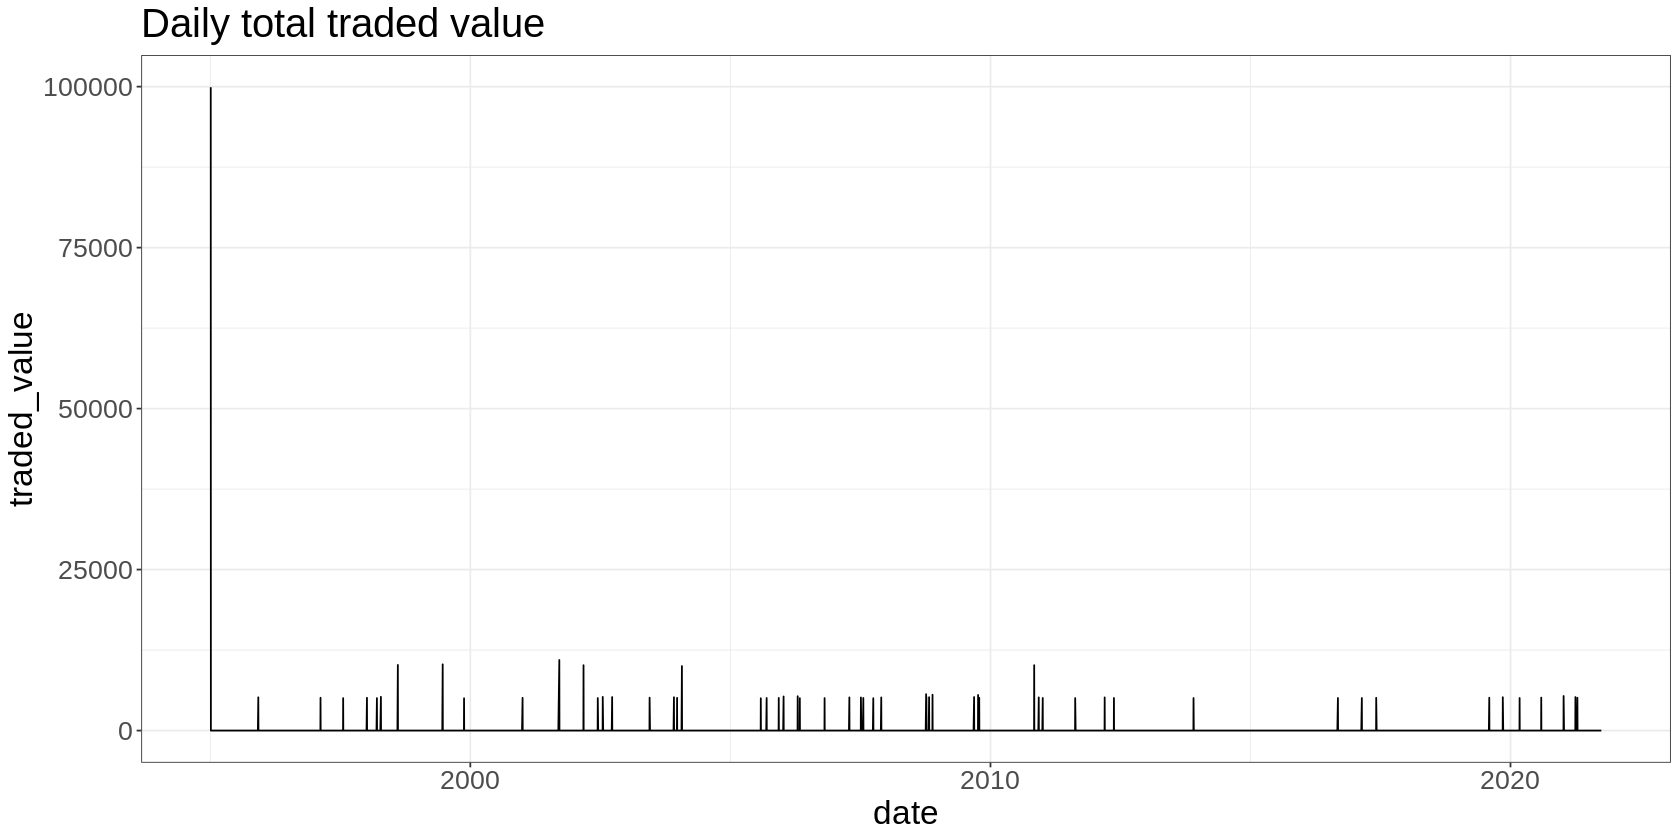

In [53]:
results_df %>%
  filter(ticker != "Cash") %>%
  group_by(date) %>%
  summarise(traded_value = sum(abs(trade_value))) %>%
  ggplot(aes(x = date, y = traded_value)) +
  geom_line() +
  labs(
   title = "Daily total traded value"
  )

You can see the trade-off: higher after-cost performance in exchange for greater tracking error with respect to your target weights.

Of course, in this case, for the trader who cares about making money in the most efficient way possible, you'd take this trade off every day of the week.

If you were an ETF manager managing to a mandate, your take on the trade off would be quite different.

Another interesting point is the dynamics of the minimum commission structure. If your account is small, you'll hit these minimum commissions more often and your commissions will be higher as a proportion of your capital.

In that case, you'd prefer to do as little trading as possible, and your preferred trade barrier would be even higher.